# Fit Basic One Current with nonlinearity Model

In [1]:
from brian2 import *
from brian2modelfitting import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
from brian2.units.constants import faraday_constant as F
from brian2.units.constants import gas_constant as R
from brian2.units.constants import zero_celsius as temp

In [4]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [5]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [6]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [7]:
np.shape(Vout)

(20, 22399)

In [8]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

In [9]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

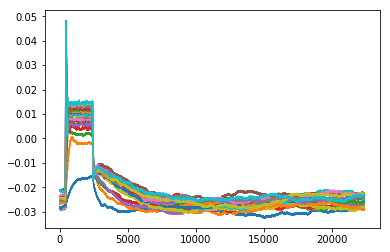

In [10]:
plot(Vout.transpose());

#### Get positive injection current

In [11]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

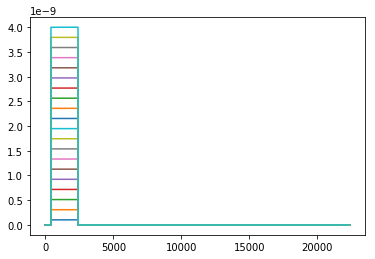

In [12]:
plot(Ic.transpose());

#### Get white noise injection

In [13]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

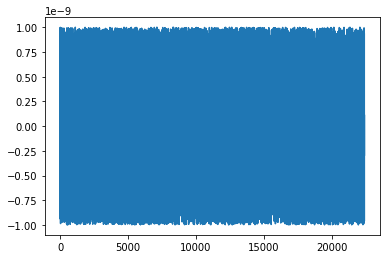

In [14]:
plot(Inoise);

#### Get V from white noise

In [15]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

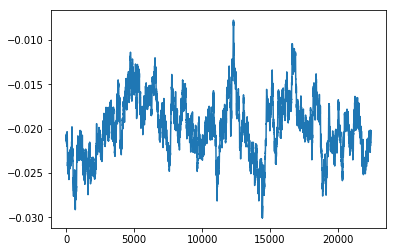

In [16]:
plot(Vnoise);

### Concatinate the data

In [17]:
output = np.concatenate((Vout[:,:10000], [Vnoise[:10000]]))
np.shape(output)

(21, 10000)

In [18]:
input_cur = np.concatenate((Ic[:, :10000], [Inoise[:10000]]))
np.shape(input_cur)

(21, 10000)

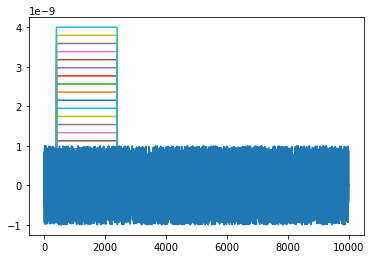

In [19]:
plot(input_cur.transpose());

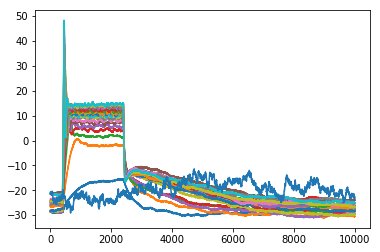

In [20]:
plot((output/1e-3).transpose());

## Define a model

In [21]:
model = Equations('''
v1 = (abs(v)+0.0001*mV)*sign(v): volt
vn = (abs(v-Vn)+0.0001*mV)*sign(v-Vn): volt

dv/dt = (gL * (EL - v) + g_k*(n)* v * ((1-exp(((Ek-v)*F)/(R*T)))/(1-exp((-v1*F)/(R*T)))) + I)/C: volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * vn/(1-exp(-vn/kn)) : Hz 
beta = -(1/(2 * kn * taun)) * vn/(1-exp(vn/kn)) : Hz 
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              
)

In [22]:
n_opt = NevergradOptimizer()
metric = MSEMetric()

## Fitting

In [23]:
fitter = TraceFitter(model=model, input_var='I', output_var='v',
                     input=input_cur * amp, output=output * volt, dt=dt,
                     n_samples=60,
                     param_init={'v': -30*mV},
                     method='exponential_euler',)

In [24]:
res, error = fitter.fit(n_rounds=50,
                        optimizer=n_opt, metric=metric,
                        callback='text',
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-1*uS, 1e4*uS],
                        taun=[1*ms, 40*ms],
                       )

WARNING    neurons's variable 'n' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/nevergrad/optimization/base.py:284: UserWarning: Updating fitness with nan value
  warnings.warn(f"Updating fitness with {value} value")
 [py.warnings]


Round 0: fit (0.0189121489396065, 0.003945851366539882, 0.007803037343212168, 1.5744915690599398e-10, 1.167445500207477e-08, -0.00468317987770875, -0.014363138996976603, -0.03699492086605445) with error: 1312.2410051996935
Round 1: fit (0.019815790139789152, 0.0013264451639225985, 0.006727380016191095, 2.664266980355507e-10, 1.3707233473229504e-08, 0.0036103019248881784, -0.014152886284930166, -0.04516349838610968) with error: 54.13871791730909
Round 2: fit (0.010203376747694426, 0.0018788358581274499, 0.006926552720922125, 2.2044699873602697e-10, 9.724390861283056e-09, 0.01259667917820469, -0.009770449489159387, -0.04410922200874109) with error: 38.76083678861147
Round 3: fit (0.006095085926017835, 0.001246333544040299, 0.005958809646499385, 3.570975426496239e-10, 9.694426166647655e-09, 0.014896164105573038, -0.005909635528008363, -0.04588955231904767) with error: 18.03664468484215
Round 4: fit (0.008099923654695727, 0.0006832779079270941, 0.006280741221347918, 3.6961562790518545e-10,

WARNING    /home/alteska/Desktop/brian/brian2modelfitting/brian2modelfitting/modelfitting/metric.py:201: RuntimeWarning: overflow encountered in square
  mse = sum(square(temp_out - trace))
 [py.warnings]


Round 5: fit (0.009648069112239699, 0.0005540766283289675, 0.005889418379158851, 3.7944045914739115e-10, 1.0568782685550305e-08, 0.015458686854574846, -0.007639928287361361, -0.039199934177996144) with error: 12.298318285438018
Round 6: fit (0.0058011233256244805, 0.0005333823927015056, 0.005427588589898215, 3.864045019498962e-10, 8.89730242243055e-09, 0.017674753603370053, -0.004087161964756156, -0.042177757082847225) with error: 9.305307174765879
Round 7: fit (0.009648069112239699, 0.0005540766283289675, 0.005428897190044253, 3.8633569596173765e-10, 1.0568782685550305e-08, 0.01822671926514455, -0.005038721019858465, -0.03587093053510266) with error: 8.288739266461993
Round 8: fit (0.007589412284166434, 0.0006157854068780484, 0.00569882909423078, 3.857484607680083e-10, 1.2184538262905353e-08, 0.017991761849647733, -0.006548829789447479, -0.019379765109038893) with error: 7.511392315401237
Round 9: fit (0.008211828865371466, 0.00038664829947648686, 0.005373772694160881, 3.9049969974714

In [25]:
## Show results
all_output = fitter.results(format='dataframe')
# print(all_output)

In [26]:
## Visualization of the results
start_scope()
fits = fitter.generate_traces(params=None, param_init={'v': -30*mV})

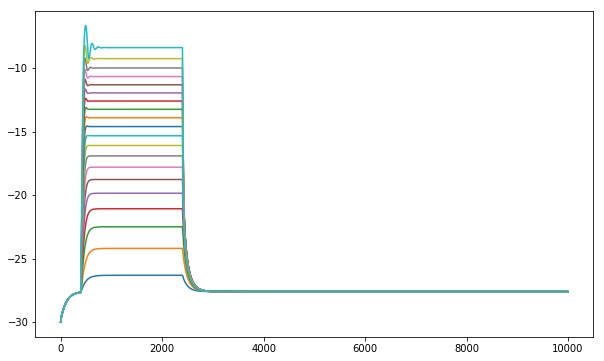

In [27]:
plt.figure(figsize=(10,6))
plot((fits[:-1]/mV).transpose());

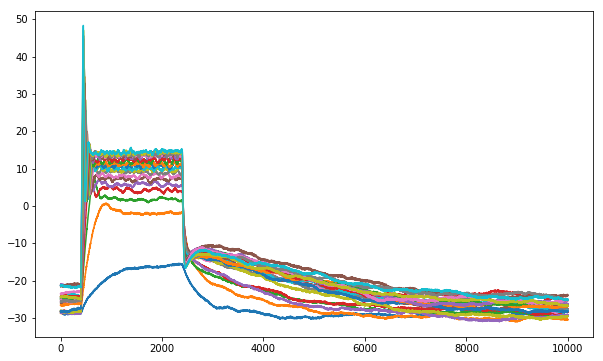

In [28]:
plt.figure(figsize=(10,6))
plot((output[:-1]/1e-3).transpose());